In [1]:
import argparse
from models.model_resnet import *
from models.model_resnet18 import *
import myData.iDataset
import myData.iDataLoader
from utils import *
from sklearn.utils import shuffle
import trainer.trainer_warehouse
import trainer.evaluator
from myData.data_warehouse import *
import easydict
from models.W_resnet import *
from sklearn.metrics import pairwise_distances
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp

In [2]:
args = easydict.EasyDict({"batch_size": 128,
                          "replay_batch_size": 64,
                          "lr": 0.1,
                          "bft_lr" : 0.01,
                          "schedule": [60,80],
                          "bft_schedule": [30,40],
                          "gammas" : [0.1, 0.1,0.1],
                          "momentum" : 0.9,
                          "seed" : 1,
                          "decay" : 0.0005,
                          "step_size" : 50,
                          "nepochs" : 100,
                          "workers" : 0,
                          "start_classes" : 50,
                          "myData" : 'CIFAR100',
                          "memory_size" : 2000,
                          "dataset" : "CIFAR100",
                          "device" : "cuda",
                          "KD" : "naive_global",
                          "trainer" : 'wa', 
                          "CCtriplet" : True,
                          "distance" : "Eucledian",
                          "beta" : 1,
                          "margin" : 0.5,
                          "triplet_lam" : 0.5,
                          "dict_type" : "softmax",
                          "dict_update" : True,
                          "new_WA" : False,
                          "triplet_epoch" : 10,
                          "anchor_update_epoch" : 10,
                          "GPU_NUM" : 0,
                          "model" : "resnet32"})

# Load trained model

In [3]:
models_dir = "./checkpoint/figure_model/"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
total_task = 20
tasknum = 9


if args.CCtriplet :
    model_dir = os.path.join(models_dir, 'base_{}_{}_tri{}_trilam{}_newWA{}_{}_{}_{}.pt'.format(args.trainer, args.dataset,args.CCtriplet, args.triplet_lam, args.new_WA, total_task, tasknum, args.model))
else :
    model_dir = os.path.join(models_dir, 'base_{}_{}_tri{}_newWA{}_{}_{}_{}.pt'.format(args.trainer, args.dataset,args.CCtriplet,args.new_WA, total_task, tasknum, args.model))
print(model_dir)
saved_model = torch.load(model_dir, map_location='cuda:0')
numclass=100

net = resnet32(num_classes=numclass, tasknum=total_task)
net.load_state_dict(saved_model)

net.eval()
net.cuda()

print(net)


./checkpoint/figure_model/base_wa_CIFAR100_triTrue_trilam0.5_newWAFalse_20_9_resnet32.pt
CifarResNet(
  (conv_1_3x3): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage_1): Sequential(
    (0): ResNetBasicblock(
      (conv_a): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBasicblock(
      (conv_a): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), 

C:\Users\Hongjun\git_repository\CL_sampling\models\model_resnet.py:92: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


# Load dataset

In [4]:

GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device)
print("current cuda : ", torch.cuda.current_device())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')



#seed
seed = args.seed
set_seed(seed)

data = DatasetWH
dataset = data.get_dataset(args.dataset)
tasknum = (dataset.classes - args.start_classes) // args.step_size + 1


shuffle_idx = shuffle(np.arange(dataset.classes), random_state = 1)


test_dataset_loader = myData.iDataLoader.IncrementalLoader(dataset.test_data,
                                                            dataset.test_labels,
                                                            dataset.classes,
                                                            args.step_size,
                                                            args.memory_size,
                                                            'test',
                                                            transform=dataset.test_transform,
                                                            loader=None,
                                                            shuffle_idx=shuffle_idx,
                                                            base_classes=args.start_classes,
                                                            approach= "wa",
                                                            args = args
                                                            )


test_iterator = torch.utils.data.DataLoader(test_dataset_loader, batch_size=100, shuffle=False)

testType = "trainedClassifier"

C:\Users\Hongjun\Anaconda3\envs\pytorch_project\lib\site-packages\torch\cuda\memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


current cuda :  0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Files already downloaded and verified
Files already downloaded and verified
[49 33 72 ... 51 42 70]
Label shuffled


In [5]:

target_list = []

class_prob = []
def one_epoch_test(testloader=None, current_epoch=None):
    global best_acc
    global best_class_acc
    criterion = nn.CrossEntropyLoss()

    print('\nEpoch: %d' % current_epoch)
    print("Testing...")

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    class_correct = 0
    class_acc = []
    prob = 0
    #class_prob = []

    with torch.no_grad():
        for inputs, targets, traindata_idx in tqdm(testloader):
            inputs = inputs.float().cuda()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)[:, :args.start_classes]

            _, predicted = outputs.max(1)
            total += targets.size(0)

            class_correct += predicted.eq(targets).sum().item()
            correct += predicted.eq(targets).sum().item()
            prob += torch.mean(F.softmax(outputs, dim=1), dim=0)

            acc = correct / total

        if acc > best_acc:
            best_acc = acc
            best_class_acc = class_acc
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': current_epoch,
            }

        print(best_acc)
        
def run_featureMap(testloader = None, model = None, current_epoch=None) :
    #print('\nEpoch: %d' % current_epoch)
    print("Testing...")
    
    model = model.cuda()
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    class_correct = 0
    class_acc = []

    with torch.no_grad():
        for inputs, targets, traindata_idx in testloader :
            inputs = inputs.float().cuda()
            targets = targets.type(dtype=torch.long).cuda()

            outputs, features = model(inputs, feature_return = True)

            
            targets, features = targets.cpu(), features.cpu()
            target_list.append(targets)
            feature_output_list.append(features)     

# Get feature map for each class

In [6]:

def get_avg_feature_map(net) :
    best_class_acc = 0
    best_acc = 0


    for i in range(1) :
        run_featureMap(test_iterator, net, i)

    featureMap = np.concatenate(feature_output_list)
    targetList = np.concatenate(target_list)

    class_feature = []
    avg_feature = []
    std_feature = []

    for i in range(args.start_classes) :
        class_feature.append(featureMap[i*100:(i+1)*100])
        temp_mean = np.mean(class_feature[i], axis=0)
        #temp_std = np.std(class_feature[i], axis=0)
        avg_feature.append(torch.tensor(temp_mean))
        #std_feature.append(torch.tensor(temp_std))

    classnum = args.start_classes
    cos = torch.nn.CosineSimilarity(dim=0)

    mtx = np.zeros((classnum,classnum))
    
    for i in range(classnum) :
        for j in range(classnum) :
            mtx[i,j] = cos(avg_feature[i], avg_feature[j])
    
    return mtx

In [7]:
global feature_output_list
feature_output_list = []
mtx = get_avg_feature_map(net)

Testing...


# Plot ART+WA

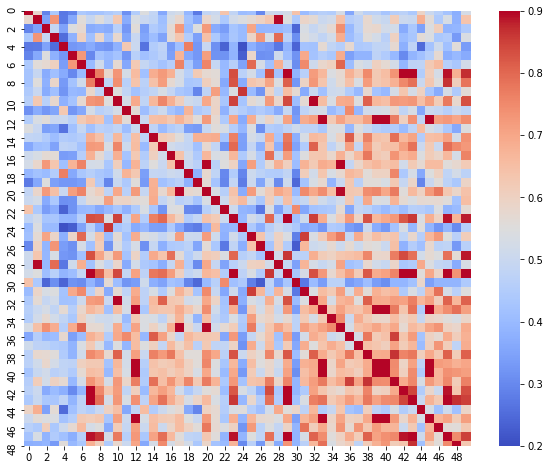

In [8]:
mp.subplots(figsize=(10,8))
sns.heatmap(mtx, annot=False, annot_kws={'size':20}, cmap="coolwarm", vmin=0.2, vmax=0.9) #dist_out : class_matrix

mp.show()

# Plot CTL+WA

Testing...


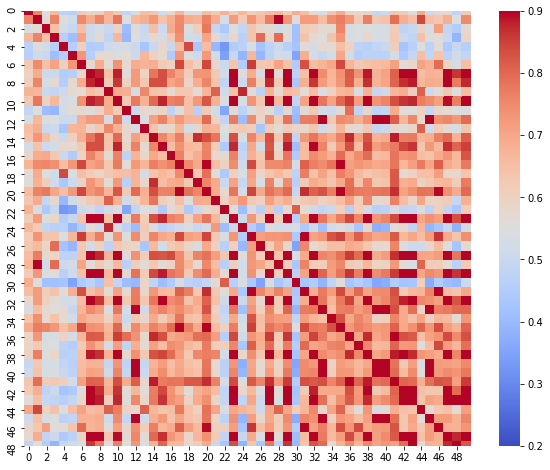

In [9]:
args.trainer = 'CTL'
models_dir = "./checkpoint/figure_model/"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
total_task = 20
tasknum = 9

if args.CCtriplet :
    model_dir = os.path.join(models_dir, 'base_{}_{}_tri{}_trilam{}_newWA{}_{}_{}_{}.pt'.format(args.trainer, args.dataset,args.CCtriplet, args.triplet_lam, args.new_WA, total_task, tasknum, args.model))
else :
    model_dir = os.path.join(models_dir, 'base_{}_{}_tri{}_newWA{}_{}_{}_{}.pt'.format(args.trainer, args.dataset,args.CCtriplet,args.new_WA, total_task, tasknum, args.model))

saved_model = torch.load(model_dir, map_location='cuda:0')
numclass=100

net = resnet32(num_classes=numclass, tasknum=total_task)

net.load_state_dict(saved_model)

net.eval()
net.cuda()

global feature_output_list
feature_output_list = []
mtx = get_avg_feature_map(net)

mp.subplots(figsize=(10,8))
sns.heatmap(mtx, annot=False, annot_kws={'size':20}, cmap="coolwarm", vmin=0.2, vmax=0.9) #dist_out : class_matrix

mp.show()

# Plot vanilla WA

Testing...


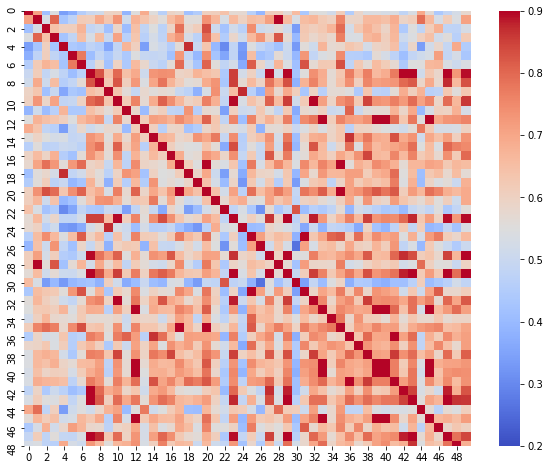

In [10]:

args.trainer = "wa"
args.CCtriplet = False

models_dir = "./checkpoint/figure_model/"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
total_task = 20
tasknum = 9

#Load model
if args.CCtriplet :
    model_dir = os.path.join(models_dir, 'base_{}_{}_tri{}_trilam{}_newWA{}_{}_{}_{}.pt'.format(args.trainer, args.dataset,args.CCtriplet, args.triplet_lam, args.new_WA, total_task, tasknum, args.model))
else :
    model_dir = os.path.join(models_dir, 'base_{}_{}_tri{}_newWA{}_{}_{}_{}.pt'.format(args.trainer, args.dataset,args.CCtriplet,args.new_WA, total_task, tasknum, args.model))

saved_model = torch.load(model_dir, map_location='cuda:0')
numclass=100

net = resnet32(num_classes=numclass, tasknum=total_task)

net.load_state_dict(saved_model)

net.eval()
net.cuda()

global feature_output_list
feature_output_list = []
mtx = get_avg_feature_map(net)

mp.subplots(figsize=(10,8))
sns.heatmap(mtx, annot=False, annot_kws={'size':20}, cmap="coolwarm", vmin=0.2, vmax=0.9) #dist_out : class_matrix

mp.show()